SAMPLmol2
0.0


[tautomers.py:358 - _perform_tautomer_transformation()] Index of atom that moves: 11.
[tautomers.py:370 - _perform_tautomer_transformation()] Index of atom that donates hydrogen: 0
[tautomers.py:388 - _perform_tautomer_transformation()] Index of atom that accepts hydrogen: 10


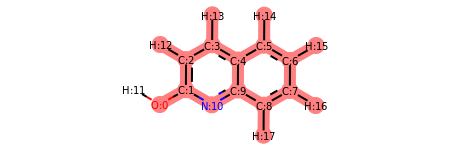

[tautomers.py:112 - add_droplet()] Adding droplet ...


Nr of atoms: 262


[restraints.py:176 - __init__()] Center Of Mass restraint added.
[ani.py:116 - minimize()] Fmax set to 0.001
[ani.py:117 - minimize()] maxstep set to 0.04


0.0
Begin minimizing...


KeyboardInterrupt: 

In [3]:
from simtk import unit
import numpy as np
from tqdm import tqdm
import mdtraj as md
import nglview
from rdkit import Chem
from rdkit.Chem import AllChem
import neutromeratio
import matplotlib.pyplot as plt
import pickle
import torchani
import torch
import os
from neutromeratio.constants import device, platform

exp_results = pickle.load(open('../data/exp_results.pickle', 'rb'))

# specify the system you want to simulate
#name = 'molDWRow_298'
#name = 'molDWRow_37'
#name = 'molDWRow_45'
#name = 'molDWRow_160'
#name = 'molDWRow_590'

# name of the system
idx = 1
# number of steps
n_steps = 50
# diameter
diameter_in_angstrom = 18
# where to write the results
base_path = '/tmp/'

mode = 'forward'

protocol = []
for name in exp_results:
    for lambda_value in np.linspace(0,1, 21):
        protocol.append((name, np.round(lambda_value, 2)))

name, lambda_value = protocol[idx-1]

print(name)
print(lambda_value)

t1_smiles = exp_results[name]['t1-smiles']
t2_smiles = exp_results[name]['t2-smiles']

# generate both rdkit mol
tautomer = neutromeratio.Tautomer(name=name, intial_state_mol=neutromeratio.generate_rdkit_mol(t1_smiles), final_state_mol=neutromeratio.generate_rdkit_mol(t2_smiles), nr_of_conformations=20)
if mode == 'forward':
    tautomer.perform_tautomer_transformation_forward()
elif mode == 'reverse':
    tautomer.perform_tautomer_transformation_reverse()
else:
    raise RuntimeError('No tautomer reaction direction was specified.')

os.makedirs(f"{base_path}/{name}", exist_ok=True)
m = tautomer.add_droplet(tautomer.hybrid_topology, 
                            tautomer.hybrid_coords, 
                            diameter=diameter_in_angstrom * unit.angstrom, 
                            file=f"{base_path}/{name}/{name}_lambda_{lambda_value:0.4f}_in_droplet_{mode}.pdb")

# define the alchemical atoms
alchemical_atoms=[tautomer.hybrid_hydrogen_idx_at_lambda_1, tautomer.hydrogen_idx]

print('Nr of atoms: {}'.format(len(tautomer.ligand_in_water_atoms)))


# extract hydrogen donor idx and hydrogen idx for from_mol
model = neutromeratio.ani.LinearAlchemicalDualTopologyANI(alchemical_atoms=alchemical_atoms)
model = model.to(device)
torch.set_num_threads(2)

# perform initial sampling
energy_function = neutromeratio.ANI1_force_and_energy(
                                        model = model,
                                        atoms = tautomer.ligand_in_water_atoms,
                                        mol = tautomer.ligand_in_water_ase_mol,
                                        )

tautomer.add_COM_for_hybrid_ligand(np.array([diameter_in_angstrom/2, diameter_in_angstrom/2, diameter_in_angstrom/2]) * unit.angstrom)

for r in tautomer.ligand_restraints:
    energy_function.add_restraint(r)

for r in tautomer.hybrid_ligand_restraints:
    energy_function.add_restraint(r)

for r in tautomer.solvent_restraints:
    energy_function.add_restraint(r)

for r in tautomer.com_restraints:
    energy_function.add_restraint(r)

print(lambda_value)
energy_and_force = lambda x : energy_function.calculate_force(x, lambda_value)
langevin = neutromeratio.LangevinDynamics(atoms = tautomer.ligand_in_water_atoms,                            
                            energy_and_force = energy_and_force)

x0 = tautomer.ligand_in_water_coordinates
x0 = energy_function.minimize(x0) # NOTE: No minimizing!

equilibrium_samples, energies, bias = langevin.run_dynamics(x0, n_steps=n_steps, stepsize=0.5 * unit.femtosecond, progress_bar=False)
   

# save equilibrium energy values 
f = open(f"{base_path}/{name}/{name}_lambda_{lambda_value:0.4f}_energy_in_droplet_{mode}.csv", 'w+')
for e in energies[::20]:
    f.write('{}\n'.format(e))
f.close()

f = open(f"{base_path}/{name}/{name}_lambda_{lambda_value:0.4f}_bias_in_droplet_{mode}.csv", 'w+')
for e in bias[::20]:
    f.write('{}\n'.format(e))
f.close()


equilibrium_samples = [x.value_in_unit(unit.nanometer) for x in equilibrium_samples]
ani_traj = md.Trajectory(equilibrium_samples[::20], tautomer.ligand_in_water_topology)
ani_traj.save(f"{base_path}/{name}/{name}_lambda_{lambda_value:0.4f}_in_droplet_{mode}.dcd", force_overwrite=True)


In [ ]:
protocol = []
exp_results = pickle.load(open('../data/exp_results.pickle', 'rb'))
for name in exp_results:
    for lambda_value in np.linspace(0,1, 21):
        protocol.append((name, np.round(lambda_value, 2)))


In [ ]:
protocol[42]

In [ ]:
#equilibrium_samples = [x.value_in_unit(unit.nanometer) for x in equilibrium_samples]
ani_traj = md.Trajectory(equilibrium_samples[::2], tautomer.ligand_in_water_topology)


In [ ]:
traj_in_nm = [x.value_in_unit(unit.nanometer) for x in equilibrium_samples]
import nglview
#ani_traj = md.Trajectory(traj_in_nm[::20], tautomer.ligand_in_water_topology)
v = neutromeratio.vis.generate_nglview_object(ani_traj)
v.add_representation(repr_type='ball+stick', selection='water', opacity=0.4, color='blue')
v.shape.add_sphere([diameter_in_angstrom/2, diameter_in_angstrom/2, diameter_in_angstrom/2], [0,0,1], diameter_in_angstrom/2-1)
v.update_representation(component=1, repr_index=0, opacity=0.2)
v

In [ ]:
energy = [x.value_in_unit(unit.kilocalorie_per_mole) for x in energies]
plt.plot(energy)

In [ ]:
a = np.array([1.,2.,4.]) * unit.angstrom

In [ ]:
a.value_in_unit(unit.angstrom)